In [229]:
# Run in python console
import nltk; nltk.download('stopwords')
import spacy

import re
import os
import numpy as np
import pandas as pd
import zipfile

from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy
import en_core_web_sm

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from langdetect import detect

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


import shutil
import glob
from tika import parser

from yellowbrick.features import rank2d
from yellowbrick.classifier import confusion_matrix
from yellowbrick.classifier import classification_report
from yellowbrick.regressor import prediction_error, ResidualsPlot

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danielacollaguazo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Importing data into DataFrame

In [291]:
path = '../data/new-york-city-airbnb-open-data/'
listings_csv = os.path.join(path,'listings.csv')

listings_df =  pd.read_csv(listings_csv,low_memory=False)

In [294]:
# for col in listings_df.columns:
#     print(col)

In [326]:
((listings_df.summary.isna().sum())/listings_df.shape[0])*100

4.8330577210804

## Exploring DataFrames

In [57]:
# Looking for text in the data
listings_df.dtypes

id                                                int64
listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
name                                             object
summary                                          object
space                                            object
description                                      object
experiences_offered                              object
neighborhood_overview                            object
notes                                            object
transit                                          object
access                                           object
interaction                                      object
house_rules                                      object
thumbnail_url                                   float64
medium_url                                      float64
picture_url                                     

In [58]:
def predict_lang(x):
    lang=''
    txt_len=len(x)
    if txt_len>50:
        try:
            lang=detect(x)
        except Exception as e:
            lang=''
    return lang

In [59]:
listings_df['content'] = listings_df['name'] + listings_df['summary']
listings_df.dropna(subset=['content'], how='any', axis=0, inplace=True)
listings_df['content_lang'] = listings_df.content.apply(lambda x: predict_lang(x))

In [60]:
# getting only text in English
listings_df=listings_df[listings_df.content_lang=='en']

In [61]:
listings_df.shape

(47690, 108)

In [62]:
def generate_list_content(df):
#     df['content'] = df['name'] + df['summary']
#     df['content'] = df['content'].replace(np.nan, '', regex=True)
    
    # Convert to list
    data = df['content'].values.tolist()

    # Remove Emails
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]

    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]
    
    
    return data

In [63]:
lst_texts = generate_list_content(listings_df)
# listings_df['content']

In [64]:
len(lst_texts)

47690

## Tokenize words and clean up text

In [65]:
# here we are tokenizing each document.
def content_to_words(lst_texts):
    for text in lst_texts:
        yield(gensim.utils.simple_preprocess(str(text), deacc=True))
        
# data_words is a list where each element is the tokenized document
tokenized_content = list(content_to_words(lst_texts))

## Create bigram and trigrams

In [66]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(tokenized_content, min_count=10, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[tokenized_content], threshold=100)  


# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

## Remove Stopwords, Make Bigrams and Lemmatize

In [67]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(tokenized_content):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in tokenized_content]

def make_bigrams(tokenized_content):
    return [bigram_mod[doc] for doc in tokenized_content]

def make_trigrams(tokenized_content):
    return [trigram_mod[bigram_mod[doc]] for doc in tokenized_content]

def lemmatization(tokenized_content, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in tokenized_content:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
nlp = en_core_web_sm.load(disable=['parser', 'ner'])

In [68]:
# Remove Stop Words
tokenized_content_nostops = remove_stopwords(tokenized_content)

# Form Bigrams
tokenized_content_bigrams = make_bigrams(tokenized_content_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
tokenized_content_lemmatized = lemmatization(tokenized_content_bigrams, 
                                             allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

## Create the Dictionary and Corpus needed for Topic Modeling

In [69]:
# Create Dictionary:
# Mapping from word IDs to words. 
# It is used to determine the vocabulary size, as well as for debugging and topic printing.
id2word = corpora.Dictionary(tokenized_content_lemmatized)
# print(len(id2word)) # corpus has 14118 unique tokens

# Term Document Frequency
# Convert document (a list of words) into the bag-of-words format = list of (token_id, token_count) 2-tuples.
# Word with their corresponding id
corpus = [id2word.doc2bow(text) for text in tokenized_content_lemmatized]

# View
# print(corpus[:1])

## Build list of topic models

In [70]:
def build_topics(num_topics):
    list_models=[]
    for n in num_topics:
        topic_name = 'lda_model_' + str(n)
        topic_name = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, 
                                                     num_topics=n, random_state=100, 
                                                     update_every=1, chunksize=100, 
                                                     passes=10, alpha='auto', 
                                                     per_word_topics=True)
        list_models.append(topic_name)
    return list_models

num_topics = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
models = build_topics(num_topics)

## Compute Model Perplexity and Coherence Score for all models

In [71]:
def calc_perplexity_coherence(models):
    list_perplexity = []
    list_coherence = []
    
    for model in models:
        list_perplexity.append(model.log_perplexity(corpus))
        coherence_model_lda = CoherenceModel(model=model, texts=tokenized_content_lemmatized, 
                                             dictionary=id2word, coherence='c_v')
        list_coherence.append(coherence_model_lda.get_coherence())
    return list_perplexity, list_coherence

x = calc_perplexity_coherence(models)      

In [72]:
df_metrics = pd.DataFrame(list(x)).transpose()
df_metrics.columns = ['Perplexity','Coherence']
df_metrics['Number of topics'] = num_topics
df_metrics

,Perplexity,Coherence,Number of topics
0,-6.574534,0.466717,2
1,-6.554022,0.522148,3
2,-6.579848,0.488070,4
3,-6.618458,0.477480,5
4,-6.653127,0.390795,6
5,-6.687945,0.428416,7
6,-6.722920,0.415193,8
7,-6.783929,0.392436,9
8,-6.879215,0.351908,10
9,-7.046815,0.342075,11


## Graphic of number of Topics and Perplexity

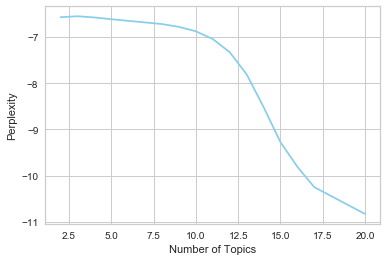

In [73]:
# Perplexity needs to be as low as possible 
plt.plot( 'Number of topics', 'Perplexity', data=df_metrics, color='skyblue')
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity")
plt.show()

## Graphic of number of Topics and Coherence

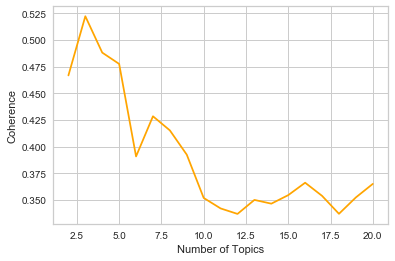

In [74]:
# Perplexity needs to be as low as possible 
plt.plot( 'Number of topics', 'Coherence', data=df_metrics, color='orange')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence")
plt.show()

## Most salient topic per file using results of Model of choice

In [75]:
# def format_topics_sentences(ldamodel=None, corpus=corpus, texts=lst_texts):
#     # Init output
#     sent_topics_df = pd.DataFrame()

#     # Get main topic in each document
#     for i, row_list in enumerate(ldamodel[corpus]):
#         row = row_list[0] if ldamodel.per_word_topics else row_list            
#         print(row)
#         row = sorted(row, key=lambda x: (x[1]), reverse=True)
#         # Get the Dominant topic, Perc Contribution and Keywords for each document
#         for j, (topic_num, prop_topic) in enumerate(row):
#             if j == 0:  # => dominant topic
#                 wp = ldamodel.show_topic(topic_num)
#                 topic_keywords = ", ".join([word for word, prop in wp])
#                 sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num) + 1, 
#                                                                   round(prop_topic,4), 
#                                                                   topic_keywords]), ignore_index=True)
#             else:
#                 break
#     sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

#     # Add original text to the end of the output
# #     contents = pd.Series(texts)
#     sent_topics_df = pd.concat([listings_df,sent_topics_df], axis=1, sort=False)
#     return(sent_topics_df)

## DataFrame with scores of all topics

In [226]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=lst_texts):
    # Init output
    sent_topics_df = list()
    listings_df.reset_index(inplace=True)
    
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        sent_topics_df.append(row)
        
    sent_topics_df = pd.DataFrame(sent_topics_df)
    sent_topics_df.columns = ['Dominant_Topic_1', 'Dominant_Topic_2', 'Dominant_Topic_3']
    sent_topics_df = pd.concat([listings_df['id'],sent_topics_df], axis=1, sort=False)
    
#     sent_topics_df.rename(columns={"id": "listing_id"},inplace=True)
    
#     sent_topics_df.set_index('listing_id',inplace=True)
    
    df_n_cols = sent_topics_df.shape[1]
    
    return sent_topics_df, df_n_cols

In [227]:
sent_topics_df, df_n_cols = format_topics_sentences(ldamodel=models[1], corpus=corpus, texts=lst_texts)

ValueError: cannot insert level_0, already exists

In [201]:
sent_topics_df.head()

,id,Dominant_Topic_1,Dominant_Topic_2,Dominant_Topic_3
0,2595,"(1, 0.68641835)","(0, 0.29845217)","(2, 0.015129453)"
1,3831,"(1, 0.79196614)","(0, 0.184401)","(2, 0.023632865)"
2,5099,"(1, 0.53317016)","(0, 0.4579125)",None
3,5178,"(1, 0.69198626)","(2, 0.157821)","(0, 0.15019271)"
4,5203,"(2, 0.3811431)","(0, 0.3187371)","(1, 0.30011985)"


In [202]:
for i in range(1,df_n_cols):
    top_col = 'topic' + str(i)
    score_col = 'score_dom_topic_' + str(i)
    
    sent_topics_df[top_col] = pd.DataFrame(sent_topics_df.iloc[:,i].tolist(), index=sent_topics_df.index)[0]
    sent_topics_df[score_col] = pd.DataFrame(sent_topics_df.iloc[:,i].tolist(), index=sent_topics_df.index)[1]

In [203]:
sent_topics_df.head()

,id,Dominant_Topic_1,Dominant_Topic_2,Dominant_Topic_3,topic1,score_dom_topic_1,topic2,score_dom_topic_2,topic3,score_dom_topic_3
0,2595,"(1, 0.68641835)","(0, 0.29845217)","(2, 0.015129453)",1,0.686418,0,0.298452,2.0,0.015129
1,3831,"(1, 0.79196614)","(0, 0.184401)","(2, 0.023632865)",1,0.791966,0,0.184401,2.0,0.023633
2,5099,"(1, 0.53317016)","(0, 0.4579125)",None,1,0.533170,0,0.457913,NaN,NaN
3,5178,"(1, 0.69198626)","(2, 0.157821)","(0, 0.15019271)",1,0.691986,2,0.157821,0.0,0.150193
4,5203,"(2, 0.3811431)","(0, 0.3187371)","(1, 0.30011985)",2,0.381143,0,0.318737,1.0,0.300120


In [204]:
cols_2_drop = ['Dominant_Topic_1', 'Dominant_Topic_2','Dominant_Topic_3']
sent_topics_df.drop(columns=cols_2_drop, inplace=True)

In [247]:
sent_topics_df.to_csv(os.path.join(path,'topics_with_scores.csv'))

In [253]:
sent_topics_df = pd.read_csv(os.path.join(path,'topics_with_scores.csv'),index_col=0)

In [257]:
sent_topics_df.head()

,Unnamed: 0.1,id,topic1,score_dom_topic_1,topic2,score_dom_topic_2,topic3,score_dom_topic_3
0,0,2595,1,0.686418,0,0.298452,2.0,0.015129
1,1,3831,1,0.791966,0,0.184401,2.0,0.023633
2,2,5099,1,0.533170,0,0.457913,NaN,NaN
3,3,5178,1,0.691986,2,0.157821,0.0,0.150193
4,4,5203,2,0.381143,0,0.318737,1.0,0.300120


In [258]:
# sent_main_topic_df = sent_topics_df[['id','topic1','score_dom_topic_1']]
sent_topics_df.rename(columns={"topic1": "winner_topic",
                                   "score_dom_topic_1":"winner_topic_score",
                                  "topic2": "second_place_topic",
                                   "score_dom_topic_2":"second_topic_score",
                                  "topic3": "third_place_topic",
                                   "score_dom_topic_3":"third_topic_score"},inplace=True)

# sent_main_topic_df.to_csv(os.path.join(path, 'winner_topic.csv'))

In [262]:
sent_topics_df = sent_topics_df.iloc[:,1:]

### Visualize the topics

In [45]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(models[1], corpus, id2word)
vis

/Users/danielacollaguazo/anaconda/envs/GTWorkshops/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.163156  0.259563       1        1  39.148720
2     -0.157467 -0.262652       2        1  35.336807
1      0.320624  0.003089       3        1  25.514471, topic_info=     Category          Freq          Term         Total  loglift  logprob
49    Default  29802.000000          room  29802.000000  30.0000  30.0000
89    Default  11184.000000          stay  11184.000000  29.0000  29.0000
54    Default  16014.000000          walk  16014.000000  28.0000  28.0000
8     Default  15890.000000        locate  15890.000000  27.0000  27.0000
197   Default   9230.000000          home   9230.000000  26.0000  26.0000
154   Default  13433.000000    restaurant  13433.000000  25.0000  25.0000
47    Default  12410.000000        minute  12410.000000  24.0000  24.0000
218   Default  17558.000000       private  17558.000000  23.0000  23.0000
351   Default  11186.000000          away  11186.000000  22.0000  22.0000
2     Default   9969.000000           bed   9969.000000  21.0000  21.0000
34    Default  23886.000000       bedroom  23886.000000  20.0000  20.0000
33    Default  37076.000000     apartment  37076.000000  19.0000  19.0000
242   Default  12572.000000         train  12572.000000  18.0000  18.0000
5     Default   8198.000000          full   8198.000000  17.0000  17.0000
280   Default   8330.000000         block   8330.000000  16.0000  16.0000
101   Default   8228.000000  neighborhood   8228.000000  15.0000  15.0000
6     Default   8161.000000         heart   8161.000000  14.0000  14.0000
393   Default   5332.000000        modern   5332.000000  13.0000  13.0000
122   Default   6938.000000         share   6938.000000  12.0000  12.0000
279   Default   7652.000000           bar   7652.000000  11.0000  11.0000
130   Default   5142.000000          view   5142.000000  10.0000  10.0000
133   Default   7290.000000         close   7290.000000   9.0000   9.0000
246   Default   6529.000000         fully   6529.000000   8.0000   8.0000
44    Default   6458.000000         large   6458.000000   7.0000   7.0000
63    Default   9530.000000      bathroom   9530.000000   6.0000   6.0000
46    Default   5976.000000        living   5976.000000   5.0000   5.0000
349   Default   7964.000000         place   7964.000000   4.0000   4.0000
52    Default   6530.000000       station   6530.000000   3.0000   3.0000
108   Default   6423.000000        subway   6423.000000   2.0000   2.0000
25    Default   8301.000000         floor   8301.000000   1.0000   1.0000
...       ...           ...           ...           ...      ...      ...
127    Topic3   1240.793945      traveler   1241.555054   1.3653  -5.5453
548    Topic3   1484.432251           top   1485.374390   1.3653  -5.3660
98     Topic3   1168.003418         hotel   1168.765137   1.3653  -5.6058
128    Topic3   1210.077026          fill   1210.903320   1.3652  -5.5704
752    Topic3   1193.658813       rooftop   1194.480347   1.3652  -5.5841
838    Topic3   1214.197510         style   1215.050781   1.3652  -5.5670
19     Topic3   1233.595825    brownstone   1234.495972   1.3652  -5.5511
2115   Topic3   1105.729614      stunning   1106.539917   1.3652  -5.6606
756    Topic3   1137.636108        unique   1138.503784   1.3652  -5.6321
5790   Topic3    792.131592         staff    792.790222   1.3651  -5.9941
347    Topic3   1004.989441         ideal   1005.837463   1.3651  -5.7561
136    Topic3   1238.246094      gorgeous   1239.294312   1.3651  -5.5474
91     Topic3   1565.297363          want   1570.384155   1.3627  -5.3130
289    Topic3   1048.041748        friend   1049.211060   1.3648  -5.7142
23     Topic3   4262.932617         enjoy   4388.527344   1.3369  -4.3111
175    Topic3   1363.552002           see   1372.205933   1.3596  -5.4510
162    Topic3   2937.764404           day   3086.363770   1.3166  -4.6834
28     Topic3   3958.827637          need   4950.094238   1.1

## Concatenating the Dominant Topics with the rest of the Features for Regression

In [263]:
model_cols_df = pd.read_csv('../data/new-york-city-airbnb-open-data/model_columns_listings.csv',index_col = 0)

In [264]:
df_model = pd.merge(left=model_cols_df, right=sent_topics_df, how='left', on='id')

In [265]:
df_model = df_model.dropna()

In [266]:
features=list()
for col in df_model.columns:
    features.append(col)

In [267]:
features.remove('price')

In [268]:
features.remove('id')

In [269]:
df_model.shape

(23987, 51)

winner_topic
0.0    13476
1.0     9518
2.0      993
Name: winner_topic, dtype: int64


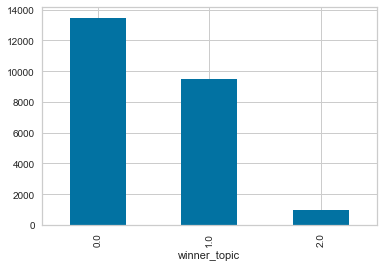

In [270]:

df = df_model.groupby('winner_topic')['winner_topic'].size()
print(df)
df.plot(kind='bar')

In [276]:
df_model.shape

(23987, 51)

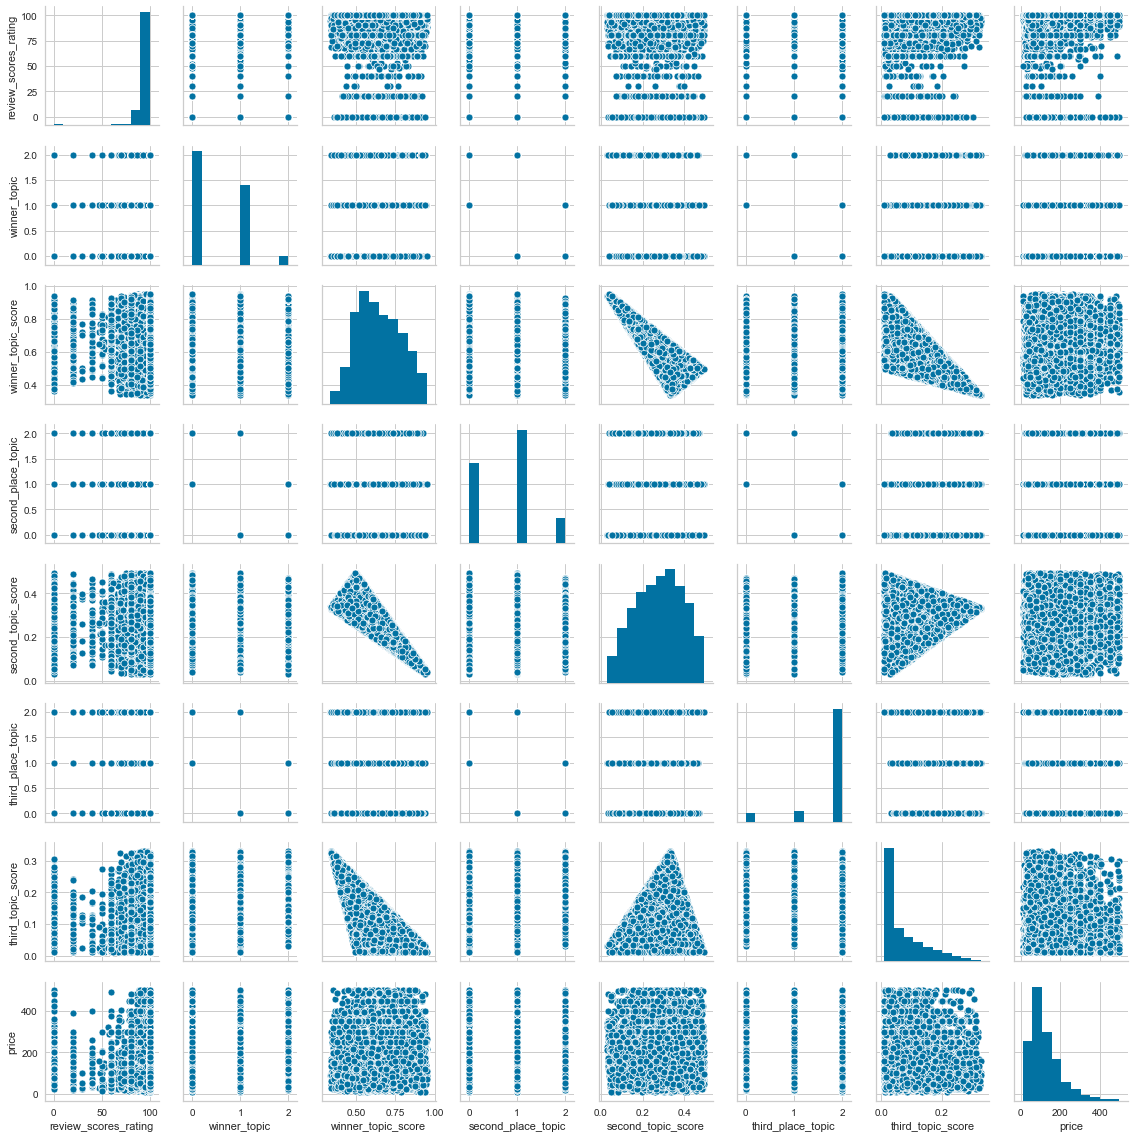

In [287]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

df_3 = df_model.loc[:,['review_scores_rating','winner_topic', 'winner_topic_score', 'second_place_topic',
                       'second_topic_score', 'third_place_topic', 'third_topic_score','price']]

sns.pairplot(df_3,height=2)

## Split train - test sets

In [278]:
X = df_model.iloc[:, 1:]
X = X.loc[:, X.columns != 'price']
y = df_model.price

In [279]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [280]:
X_train.shape, len(features)

((19189, 49), 49)

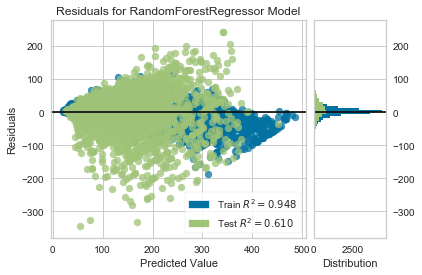

/Users/danielacollaguazo/anaconda/envs/GTWorkshops/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


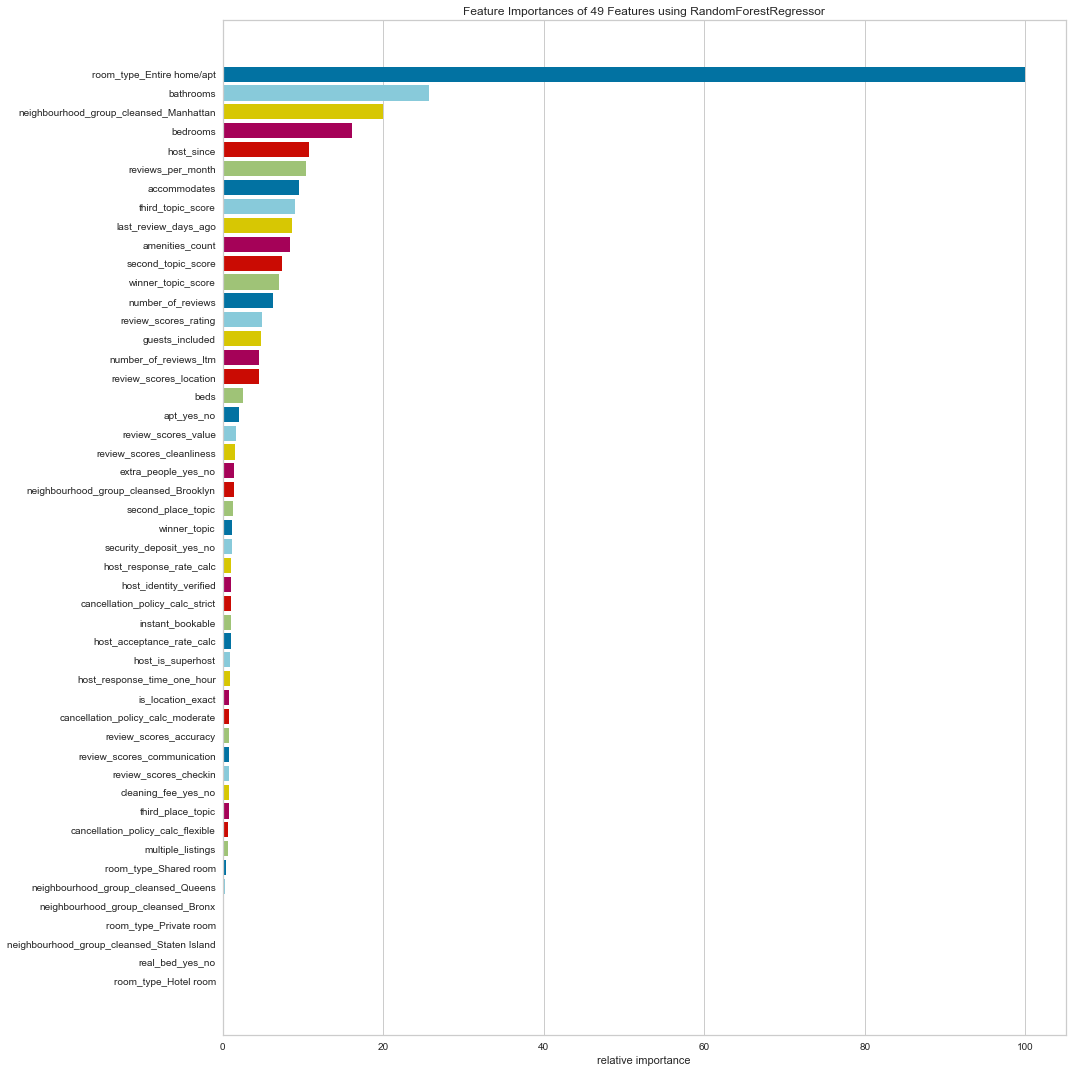

In [281]:
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge, LinearRegression
from yellowbrick.features import FeatureImportances

regressors = {
#     "support vector machine": SVR(),
#     "multilayer perceptron": MLPRegressor(),
#     "nearest neighbors": KNeighborsRegressor(),
#     "bayesian ridge": BayesianRidge(),
#     "linear regression": LinearRegression(),
    "random forest": RandomForestRegressor(),
}

for _, regressor in regressors.items():
    visualizer = ResidualsPlot(regressor)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()
    
    viz = FeatureImportances(regressor, labels=features, size=(1080, 1080))

    viz.fit(X_train, y_train)
    # Note: the FeatureImportances visualizer is a model visualizer,
    # not a feature visualizer, so it doesn't have a transform method!
    viz.show()

In [288]:
# top_features =['room_type_Entire home/apt',
# 'bathrooms',
# 'neighbourhood_group_cleansed_Manhattan',
# 'bedrooms',
# 'host_since',
# 'reviews_per_month',
# 'accommodates',
# 'third_topic_score',
# 'last_review_days_ago',
# 'amenities_count',
# 'second_topic+score',
# 'number_of_reviews',
# 'review_scores_rating',
# 'guest_included',
# 'number_of_reviews_ltm',
# 'review_scores_location',
# 'beds',
# 'apt_yes_no',
# 'review_scores_value',
# 'review_scores_cleanliness']

top_features =['bathrooms','bedrooms','reviews_per_month','price','third_topic_score']

df_4 = df_model.loc[:,top_features]

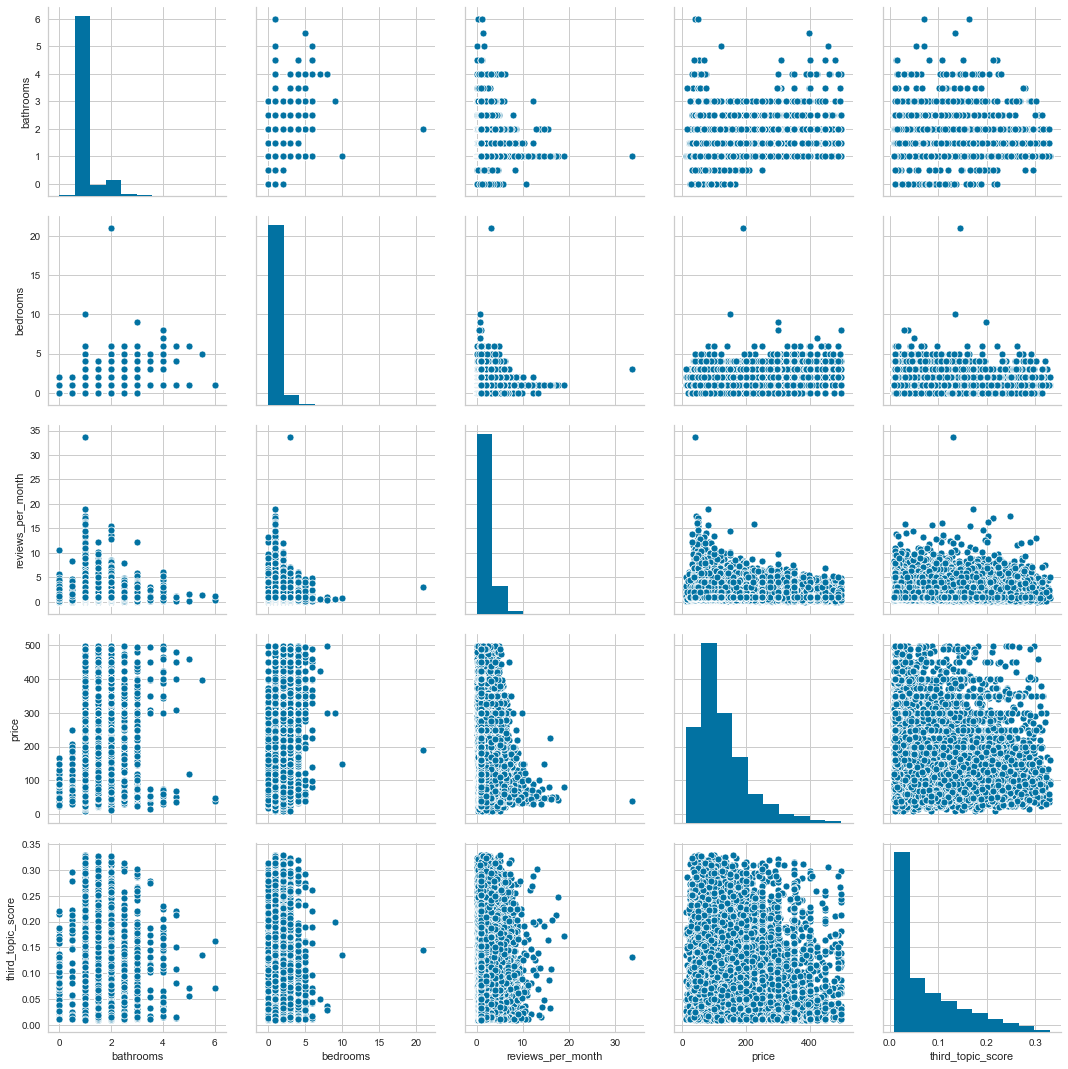

In [289]:
sns.pairplot(df_4,height=3)